# Plot master figure: MCMC dv/v model fitting

2023.4.22 Kurama Okubo

This notebook plots the master figures for MCMC dv/v model fitting.
Please first run the `plotfigure_MCMCscattermatrix.ipynb` for the case of stretching and mwcs to dump the data to plot the dvv model comparisons in this notebook.

2023.10.6 update legend

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline
from IPython.display import display, Math

import numpy as np
import pandas as pd
import h5py
import pickle

import shutil
from tqdm import tqdm
import glob

import matplotlib as mpl

import emcee # MCMC sampler
import corner

import copy

# import mcmc functions
from scattermatrix import *
from MCMC_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [2]:
starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 

# NOTE: v1_tshift0-120 is used to demonstrate the trade-off of temperature time shift
plotdvv_datadir = "../plotdvvmodel_data"
output_imgdir = "../figure/MCMC_dvvmodelfit_mastrer"

image_format="png"
dpi = 150
show=True
#-------------------------------------------#

if not os.path.exists(plotdvv_datadir):
    os.makedirs(plotdvv_datadir)
    
if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)

In [3]:
finamelist = glob.glob(plotdvv_datadir+"/*.pickle")
finamelist

['../plotdvvmodel_data/plotdvvfit_model_stretching_BP.LCCB-BP.SCYB_0.9-1.2_wlin_v2.pickle',
 '../plotdvvmodel_data/plotdvvfit_model_mwcs_BP.LCCB-BP.SCYB_0.9-1.2_wlin_v2.pickle',
 '../plotdvvmodel_data/plotdvvfit_model_mwcs_BP.LCCB-BP.SCYB_0.9-1.2_base_v2.pickle',
 '../plotdvvmodel_data/plotdvvfit_model_stretching_BP.LCCB-BP.SCYB_0.9-1.2_base_v2.pickle']

In [4]:
stationpairs_tmp = []
for finame in glob.glob(plotdvv_datadir+"/*.pickle"):
    dvvmethod, stpair, freqband, modelcase, version = os.path.basename(finame).split(".pickle")[0].split("_")[2:]
    stationpairs_tmp.append(stpair)

In [5]:
stationpair_list = np.unique(stationpairs_tmp)

In [6]:
stationpair = stationpair_list[0]
sta1, sta2 = [x.split(".")[1] for x in stationpair.split("-")]
stationpair

'BP.LCCB-BP.SCYB'

In [7]:
#read data
dvvmethod = "stretching"
freqband = "0.9-1.2"
caseversion = "v2"

# base model
fidata_stretching_base = plotdvv_datadir+"/plotdvvfit_model_{}_{}_{}_{}_{}.pickle".format(dvvmethod, stationpair, freqband, "base", caseversion)
if not os.path.exists(fidata_stretching_base):
    raise ValueError(f"{fidata_stretching_base} not exists. Please first dump the data.")
else:
    with open(fidata_stretching_base, "rb") as f:
        plotdvvfit_model_base = pickle.load(f)
        
# wlin model
fidata_stretching_wlin = plotdvv_datadir+"/plotdvvfit_model_{}_{}_{}_{}_{}.pickle".format(dvvmethod, stationpair, freqband, "wlin", caseversion)
if not os.path.exists(fidata_stretching_wlin):
    raise ValueError(f"{fidata_stretching_wlin} not exists. Please first dump the data.")
else:
    with open(fidata_stretching_wlin, "rb") as f:
        plotdvvfit_model_wlin = pickle.load(f)
        

In [8]:
fidata_stretching_wlin

'../plotdvvmodel_data/plotdvvfit_model_stretching_BP.LCCB-BP.SCYB_0.9-1.2_wlin_v2.pickle'

In [9]:
plotdvvfit_model_wlin.keys()

dict_keys(['a0', 'p1', 'a_{precip}', 'p2', 't_{shiftdays}', 'S1', 'log10tmin1', 'log10tmax1', 'S2', 'log10tmin2', 'log10tmax2', 'b_{lin}', 'logf', 'fixparam01', 'nsteps', 'nwalkers', 'modelcase', 'a_{precip}_fixed', 'log10tmin1_fixed', 'log10tmin2_fixed', 'averagestack_step', 'uniform_tvec', 'unix_tvec', 'fitting_period_ind', 'unix_tSS', 'unix_tPF', 'precip', 'CAVG', 'keys', 'pos', 'ndim', 'dvv_data_trim', 'err_data_trim', 'freqband', 'dvvmethod', 'nbin_hist', 'dvv_data', 'err_data', 'theta', 'model_keys', 'dvvgwl', 'dvvtemp', 'dvvhealSS', 'dvvhealPF', 'dvv_model', 'lintrend'])

In [10]:
t_shiftdays = plotdvvfit_model_base["theta"][plotdvvfit_model_base["model_keys"].index("t_{shiftdays}")]
t_shiftdays

31.29456273638295

## plot dvv model factors

In [11]:
plotdvvfit_model_base["theta"][4]
plotdvvfit_model_wlin["theta"][4]

30.362513731424016

In [12]:
# def rescale_theta(theta):
#     theta[5] = np.log10(10**theta[5]/86400/365)
#     theta[7] = np.log10(10**theta[7]/86400/365)
#     theta[8] = theta[8] * 365

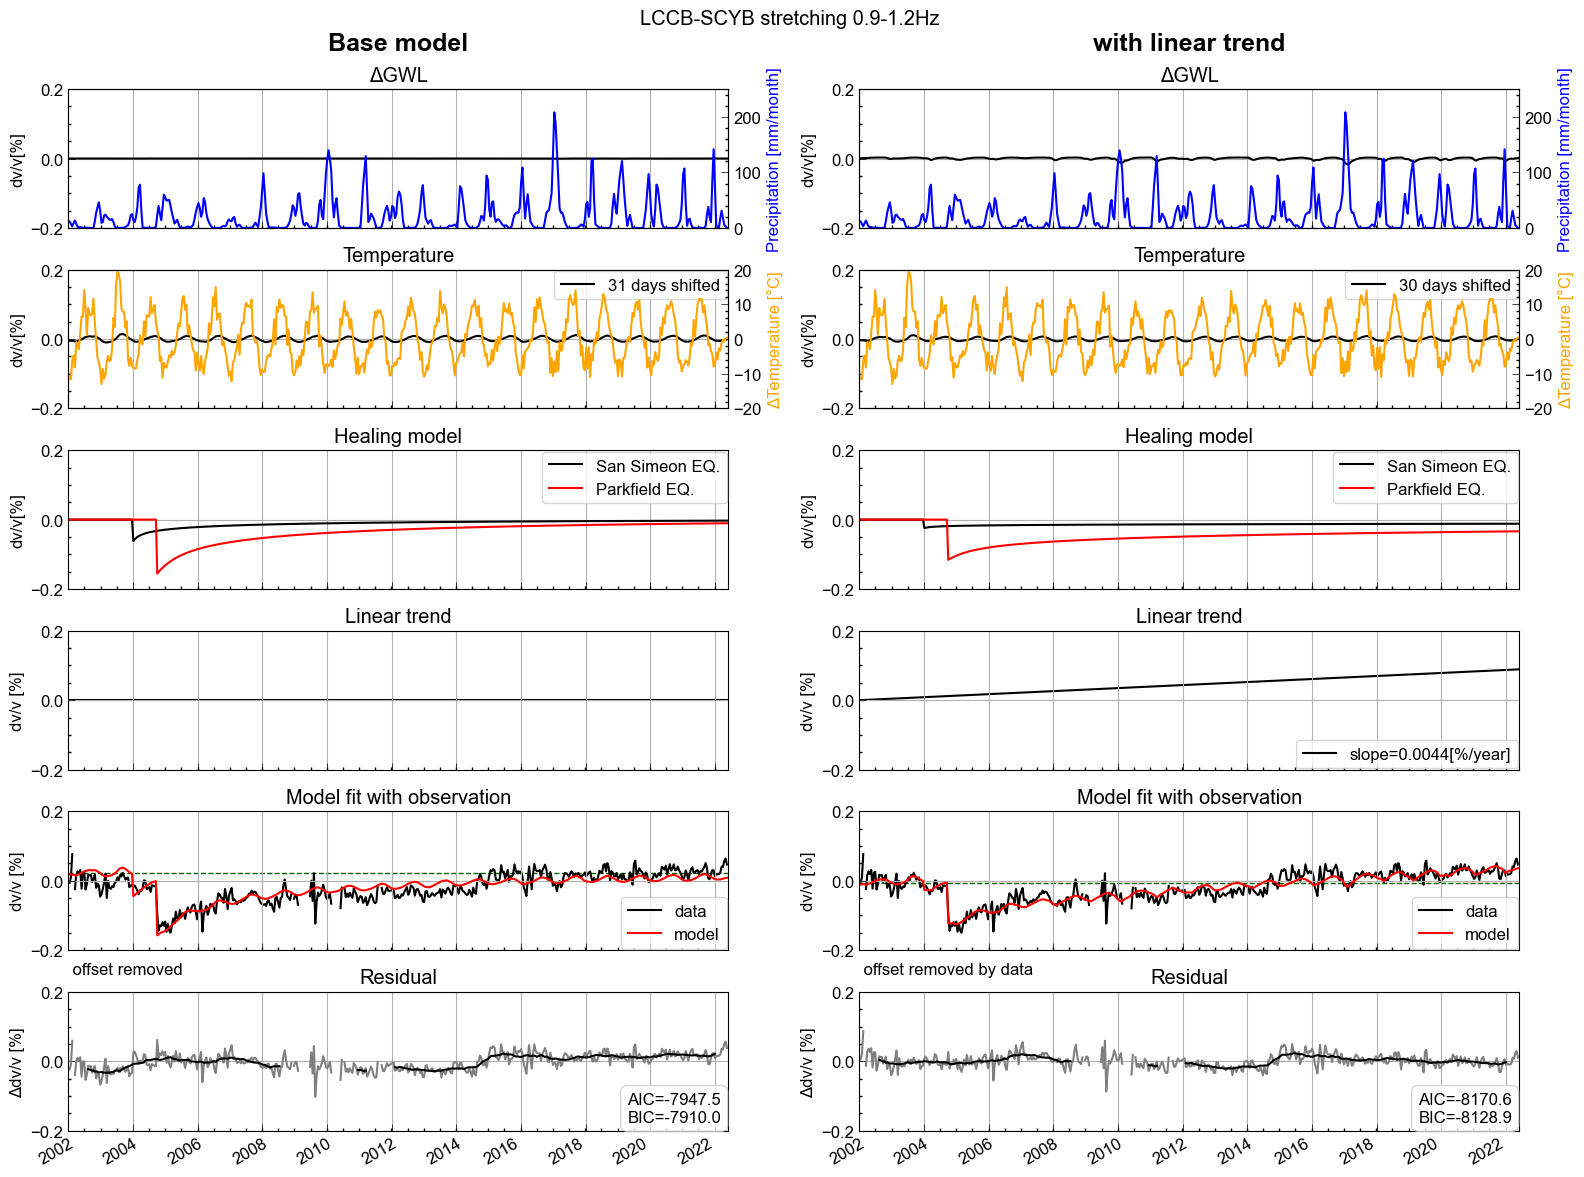

In [13]:
dvvmodel_IsOffsetRemoval = True # remove offset from the dv/v with the periof before San Simeon eq. of the observation
dicttextbox=dict(boxstyle="round", fc="w", ec=[0.8, 0.8, 0.8], alpha=0.8, pad=0.4) # text box property for AIC and BIC

modeldict = plotdvvfit_model_base

uniform_tvec = modeldict["uniform_tvec"]
tSS = datetime.datetime.fromtimestamp(modeldict["unix_tSS"])
t_shiftdays = modeldict["theta"][modeldict["model_keys"].index("t_{shiftdays}")]
a0 = modeldict["theta"][modeldict["model_keys"].index("a0")]

ii = 0

fig, axs = plt.subplots(7, 2, figsize=(16,12),sharex=True, gridspec_kw={"height_ratios":[0.01,1,1,1,1,1,1,]})

#--- Plot base model---#
# plot GWL
axs[1, ii].plot(uniform_tvec, modeldict["dvvgwl"], "k-")
axs[1, ii].set_title("ΔGWL")
axs[1, ii].set_ylabel("dv/v[%]")

ax02=axs[1, ii].twinx()
# make a plot with different y-axis using second axis object
ax02.plot(uniform_tvec, modeldict["precip"] , color="blue")
ax02.set_ylabel("Precipitation [mm/month]",color="blue")
ax02.set_ylim([0, 250])

# plot Temperature
if t_shiftdays >= 2:
    label_temperature = "{:2d} days shifted"
else:
    label_temperature = "{:2d} day shifted"
    
axs[2, ii].plot(uniform_tvec, modeldict["dvvtemp"], "k-", label=label_temperature.format(int(t_shiftdays)))
axs[2, ii].set_title("Temperature")
axs[2, ii].set_ylabel("dv/v[%]")

ax12=axs[2, ii].twinx()
# make a plot with different y-axis using second axis object
ax12.plot(uniform_tvec, modeldict["CAVG"] , color="orange")
ax12.set_ylabel("ΔTemperature [°C]",color="orange")
ax12.set_ylim([-20, 20])
axs[2, ii].legend(loc=1, bbox_to_anchor=(1.01, 1.05))
# axs[1, ii].legend(loc=4, bbox_to_anchor=(1.0, -0.03),)#(1.02, 1.0),)


# plot SS and PF healing
axs[3, ii].plot(uniform_tvec, modeldict["dvvhealSS"], "k-", label="San Simeon EQ.")
axs[3, ii].plot(uniform_tvec, modeldict["dvvhealPF"], "r-", label="Parkfield EQ.")
axs[3, ii].set_title("Healing model")
axs[3, ii].set_ylabel("dv/v[%]")
axs[3, ii].legend(loc=1, bbox_to_anchor=(1.01, 1.05))

# plot trend
axs[4, ii].plot(uniform_tvec, modeldict["lintrend"], ls="-", c = "k", zorder=1)
axs[4, ii].set_title("Linear trend")
axs[4, ii].set_ylabel("dv/v [%]")

# plot dv/v
if dvvmodel_IsOffsetRemoval:
    offset_ind = np.where(np.array(uniform_tvec) < tSS)
    offset_data = np.nanmean(modeldict["dvv_data"][offset_ind])
    dvv_data = modeldict["dvv_data"] - offset_data
    dvv_model = modeldict["dvv_model"] - offset_data
    a0_offsetremoved = a0 - offset_data
    axs[5, ii].text(starttime, -0.27, " offset removed")
else:
    dvv_data = modeldict["dvv_data"]
    dvv_model = modeldict["dvv_model"]
    a0_offsetremoved = a0
          
# axs[3].errorbar(uniform_tvec, dvv_data, yerr = err_data, capsize=3, ls="-", c = "k", ecolor='black', zorder=1, label="data")
axs[5, ii].plot(uniform_tvec, dvv_data, ls="-", c = "k", zorder=1, label="data")
axs[5, ii].plot(uniform_tvec, dvv_model, "r-", zorder=2, label="model")
axs[5, ii].set_title("Model fit with observation")
axs[5, ii].set_ylabel("dv/v [%]")
axs[5, ii].legend(loc=4, bbox_to_anchor=(1.01, -0.05))

axs[5, ii].axhline(a0_offsetremoved, c="darkgreen", ls="--", lw=1, zorder=-1, label="")

# plot residual
axs[6, ii].plot(uniform_tvec, dvv_data-dvv_model, "-", c="gray", zorder=2, label="raw")
axs[6, ii].plot(uniform_tvec, moving_average(dvv_data-dvv_model, 20), "k-", zorder=2, label="smoothed")
axs[6, ii].set_title("Residual")
axs[6, ii].set_ylabel("Δdv/v [%]")
# axs[6, ii].legend(loc=4, bbox_to_anchor=(1.01, -0.05))

AIC_base = compute_AIC(dvv_data*1e-2, dvv_model*1e-2, modeldict["ndim"]) # convert from % to nondim
BIC_base = compute_BIC(dvv_data*1e-2, dvv_model*1e-2, modeldict["ndim"]) # convert from % to nondim
axs[6, ii].text(0.918, 0.16, "AIC={:.1f}\nBIC={:.1f}".format(AIC_base, BIC_base), ha="center", va="center", bbox=dicttextbox, transform=axs[6, ii].transAxes)


#---------------------------------------------------------------------------------#
#---------------------------------------------------------------------------------#

#--- Plot wlin---#
ii = 1
modeldict = plotdvvfit_model_wlin

uniform_tvec = modeldict["uniform_tvec"]
tSS = datetime.datetime.fromtimestamp(modeldict["unix_tSS"])
t_shiftdays = modeldict["theta"][modeldict["model_keys"].index("t_{shiftdays}")]
blin_peryear = modeldict["theta"][modeldict["model_keys"].index("b_{lin}")] * 365
a0 = modeldict["theta"][modeldict["model_keys"].index("a0")]

# plot GWL
axs[1, ii].plot(uniform_tvec, modeldict["dvvgwl"], "k-")
axs[1, ii].set_title("ΔGWL")
axs[1, ii].set_ylabel("dv/v[%]")

ax02=axs[1, ii].twinx()
# make a plot with different y-axis using second axis object
ax02.plot(uniform_tvec, modeldict["precip"] , color="blue")
ax02.set_ylabel("Precipitation [mm/month]",color="blue")
ax02.set_ylim([0, 250])

# plot Temperature
if t_shiftdays >= 2:
    label_temperature = "{:2d} days shifted"
else:
    label_temperature = "{:2d} day shifted"
    
axs[2, ii].plot(uniform_tvec, modeldict["dvvtemp"], "k-", label=label_temperature.format(int(t_shiftdays)))
axs[2, ii].set_title("Temperature")
axs[2, ii].set_ylabel("dv/v[%]")

ax12=axs[2, ii].twinx()
# make a plot with different y-axis using second axis object
ax12.plot(uniform_tvec, modeldict["CAVG"] , color="orange")
ax12.set_ylabel("ΔTemperature [°C]",color="orange")
ax12.set_ylim([-20, 20])
axs[2, ii].legend(loc=1, bbox_to_anchor=(1.01, 1.05))
# axs[1, ii].legend(loc=4, bbox_to_anchor=(1.0, 0.75),)#(1.02, 1.0),)

# plot SS and PF healing
axs[3, ii].plot(uniform_tvec, modeldict["dvvhealSS"], "k-", label="San Simeon EQ.")
axs[3, ii].plot(uniform_tvec, modeldict["dvvhealPF"], "r-", label="Parkfield EQ.")
axs[3, ii].set_title("Healing model")
axs[3, ii].set_ylabel("dv/v[%]")
axs[3, ii].legend(loc=1, bbox_to_anchor=(1.01, 1.05))

# plot trend
axs[4, ii].plot(uniform_tvec, modeldict["lintrend"], ls="-", c = "k", zorder=1, label="slope={:.4f}[%/year]".format(blin_peryear))
axs[4, ii].set_title("Linear trend")
axs[4, ii].set_ylabel("dv/v [%]")
axs[4, ii].legend(loc=4, bbox_to_anchor=(1.01, -0.05))

# plot dv/v
if dvvmodel_IsOffsetRemoval:
    offset_ind = np.where(np.array(uniform_tvec) < tSS)
    offset_data = np.nanmean(modeldict["dvv_data"][offset_ind])
    dvv_data = modeldict["dvv_data"] - offset_data
    dvv_model = modeldict["dvv_model"] - offset_data
    a0_offsetremoved = a0 - offset_data
    axs[5, ii].text(starttime, -0.27, " offset removed by data")
else:
    dvv_data = modeldict["dvv_data"]
    dvv_model = modeldict["dvv_model"]
    a0_offsetremoved = a0
       
# axs[3].errorbar(uniform_tvec, dvv_data, yerr = err_data, capsize=3, ls="-", c = "k", ecolor='black', zorder=1, label="data")
axs[5, ii].plot(uniform_tvec, dvv_data, ls="-", c = "k", zorder=1, label="data")
axs[5, ii].plot(uniform_tvec, dvv_model, "r-", zorder=2, label="model")
axs[5, ii].set_title("Model fit with observation")
axs[5, ii].set_ylabel("dv/v [%]")
axs[5, ii].legend(loc=4, bbox_to_anchor=(1.01, -0.05))
axs[5, ii].axhline(a0_offsetremoved, c="darkgreen", ls="--", lw=1, zorder=-1, label="")

# plot residual
axs[6, ii].plot(uniform_tvec, dvv_data-dvv_model, "-", c="gray", zorder=2, label="raw")
axs[6, ii].plot(uniform_tvec, moving_average(dvv_data-dvv_model, 20), "k-", zorder=2, label="smoothed")
axs[6, ii].set_title("Residual")
axs[6, ii].set_ylabel("Δdv/v [%]")
# axs[6, ii].legend(loc=4, bbox_to_anchor=(1.01, -0.05))

#---------------------------------------------------------------------------------#

for i in range(len(axs)):
    for ii in range(2):
        axs[i, ii].grid(True)
        axs[i, ii].set_yticks([-0.2, 0.0, 0.2])
        plt.setp(axs[i, ii].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

plt.setp(axs, xlim=[starttime, endtime])
plt.setp(axs, ylim=[-0.2,0.2])

AIC_wlin = compute_AIC(dvv_data*1e-2, dvv_model*1e-2, modeldict["ndim"]) # convert from % to nondim
BIC_wlin = compute_BIC(dvv_data*1e-2, dvv_model*1e-2, modeldict["ndim"]) # convert from % to nondim
axs[6, ii].text(0.918, 0.16, "AIC={:.1f}\nBIC={:.1f}".format(AIC_wlin, BIC_wlin), ha="center", va="center", bbox=dicttextbox, transform=axs[6, ii].transAxes)

plt.suptitle(f"{sta1}-{sta2} {dvvmethod} {freqband}Hz ")

fig.tight_layout()
plt.subplots_adjust(hspace=0.35)
# set titles
for i, txt in enumerate(["Base model", "with linear trend"]):
    axs[0, i].axis('off')
    axs[0, i].set_title(txt, pad=0.0, y=-2, fontsize=18, fontweight="bold")

# vlines = [datetime.datetime(2002, 1, 1), datetime.datetime(2020, 9, 1)] 
# ax.axvline(vlines[0], ls="-", c='b')
# ax.axvline(vlines[1], ls="-", c='b')

foname = (output_imgdir+"/MCMC_modelfitfactors_master_{}_{}_{}.png".format(stationpair, dvvmethod, freqband))
plt.savefig(foname, dpi=300)

In [14]:
stationpair

'BP.LCCB-BP.SCYB'